https://www.kaggle.com/code/seungmoklee/3-lstms-with-data-picking-and-shifting#Set-Detector-Geometry

In [6]:
import numpy as np
import pandas as pd

from icecube import constants

In [7]:
# sensor_geometry
sensor_geometry_df = pd.read_csv(constants.raw_data_dir / "sensor_geometry.csv")

# counts
doms_per_string = 60
string_num = 86

# index
outer_long_strings = np.concatenate(
    [np.arange(0, 25), np.arange(27, 34), np.arange(37, 44), np.arange(46, 78)]
)
inner_long_strings = np.array([25, 26, 34, 35, 36, 44, 45])
inner_short_strings = np.array([78, 79, 80, 81, 82, 83, 84, 85])

# known specs
outer_xy_resolution = 125.0 / 2
inner_xy_resolution = 70.0 / 2
long_z_resolution = 17.0 / 2
short_z_resolution = 7.0 / 2

# evaluate error
sensor_x = sensor_geometry_df.x
sensor_y = sensor_geometry_df.y
sensor_z = sensor_geometry_df.z
sensor_r_err = np.ones(doms_per_string * string_num)
sensor_z_err = np.ones(doms_per_string * string_num)

for string_id in outer_long_strings:
    sensor_r_err[
        string_id * doms_per_string : (string_id + 1) * doms_per_string
    ] *= outer_xy_resolution
    
for string_id in np.concatenate([inner_long_strings, inner_short_strings]):
    sensor_r_err[
        string_id * doms_per_string : (string_id + 1) * doms_per_string
    ] *= inner_xy_resolution

for string_id in outer_long_strings:
    sensor_z_err[
        string_id * doms_per_string : (string_id + 1) * doms_per_string
    ] *= long_z_resolution

for string_id in np.concatenate([inner_long_strings, inner_short_strings]):
    for dom_id in range(doms_per_string):
        z = sensor_z[string_id * doms_per_string + dom_id]
        if (z < -156.0) or (z > 95.5 and z < 191.5):
            sensor_z_err[
                string_id * doms_per_string + dom_id
            ] *= short_z_resolution

# register
sensor_geometry_df["r_err"] = sensor_r_err
sensor_geometry_df["z_err"] = sensor_z_err


In [8]:
# detector constants
c_const = 0.299792458  # speed of light [m/ns]

x_min = sensor_x.min()
x_max = sensor_x.max()
y_min = sensor_y.min()
y_max = sensor_y.max()
z_min = sensor_z.min()
z_max = sensor_z.max()

detector_length = np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2 + (z_max - z_min)**2)
t_valid_length = detector_length / c_const

print("t_valid_length: ", t_valid_length, " ns")

t_valid_length:  6199.700247193777  ns


In [36]:
bin_num = 16

azimuth_edges = np.linspace(0, 2 * np.pi, bin_num + 1)
azimuth_shift = (azimuth_edges[1] - azimuth_edges[0]) / 2.

zenith_edges_flat = np.linspace(0, np.pi, bin_num + 1)
zenith_edges = list()
zenith_edges.append(0)
for bin_idx in range(1, bin_num):
    # cos(zen_before) - cos(zen_now) = 2 / bin_num
    zen_now = np.arccos(np.cos(zenith_edges[-1]) - 2 / bin_num)
    zenith_edges.append(zen_now)
zenith_edges.append(np.pi)
zenith_edges = np.array(zenith_edges)

/home/eden/anaconda3/envs/icecube/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


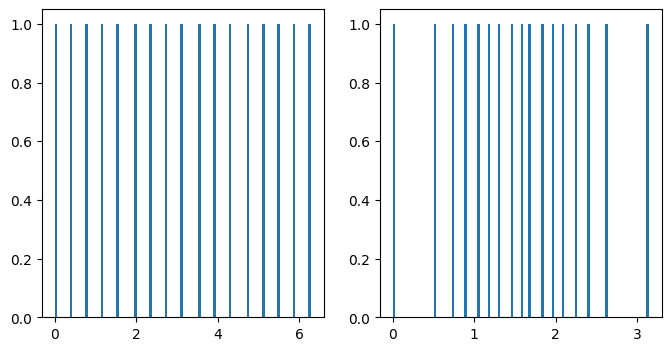

In [39]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot(1, 2, 1)
ax.hist(azimuth_edges, bins=100)

ax = fig.add_subplot(1, 2, 2)
ax.hist(zenith_edges, bins=100)

fig.show()

In [45]:
def y_to_onehot(batch_y):
    # evaluate bin code
    azimuth_code = (batch_y[:, 0] > azimuth_edges[1:].reshape((-1, 1))).sum(axis=0)
    zenith_code = (batch_y[:, 1] > zenith_edges[1:].reshape((-1, 1))).sum(axis=0)
    angle_code = bin_num * azimuth_code + zenith_code

    # one-hot
    batch_y_onehot = np.zeros((angle_code.size, bin_num * bin_num))
    batch_y_onehot[np.arange(angle_code.size), angle_code] = 1
    
    return batch_y_onehot

In [48]:
angle_bin_zenith0 = np.tile(zenith_edges[:-1], bin_num)
angle_bin_zenith1 = np.tile(zenith_edges[1:], bin_num)
angle_bin_azimuth0 = np.repeat(azimuth_edges[:-1], bin_num)
angle_bin_azimuth1 = np.repeat(azimuth_edges[1:], bin_num)

angle_bin_area = (angle_bin_azimuth1 - angle_bin_azimuth0) * (np.cos(angle_bin_zenith0) - np.cos(angle_bin_zenith1))
angle_bin_vector_sum_x = (np.sin(angle_bin_azimuth1) - np.sin(angle_bin_azimuth0)) * ((angle_bin_zenith1 - angle_bin_zenith0) / 2 - (np.sin(2 * angle_bin_zenith1) - np.sin(2 * angle_bin_zenith0)) / 4)
angle_bin_vector_sum_y = (np.cos(angle_bin_azimuth0) - np.cos(angle_bin_azimuth1)) * ((angle_bin_zenith1 - angle_bin_zenith0) / 2 - (np.sin(2 * angle_bin_zenith1) - np.sin(2 * angle_bin_zenith0)) / 4)
angle_bin_vector_sum_z = (angle_bin_azimuth1 - angle_bin_azimuth0) * ((np.cos(2 * angle_bin_zenith0) - np.cos(2 * angle_bin_zenith1)) / 4)

angle_bin_vector_mean_x = angle_bin_vector_sum_x / angle_bin_area
angle_bin_vector_mean_y = angle_bin_vector_sum_y / angle_bin_area
angle_bin_vector_mean_z = angle_bin_vector_sum_z / angle_bin_area

angle_bin_vector = np.zeros((1, bin_num * bin_num, 3))
angle_bin_vector[:, :, 0] = angle_bin_vector_mean_x
angle_bin_vector[:, :, 1] = angle_bin_vector_mean_y
angle_bin_vector[:, :, 2] = angle_bin_vector_mean_z

angle_bin_vector_unit = angle_bin_vector[0].copy()
angle_bin_vector_unit /= np.sqrt((angle_bin_vector_unit**2).sum(axis=1).reshape((-1, 1)))

In [50]:
angle_bin_vector_unit.shape

(256, 3)